In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

#Creating final dataset
data = pd.merge(specs[['ID_library', 'smiles']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1','Labels']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,Labels
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,0
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,0
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,0
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,0
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,0


In [3]:
data.groupby('Labels').count()

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1
Labels,,,
0,5121,5121,5121
1,51,51,51


In [4]:
# First we need to parse the SMILES and create RDKit 'molecule' objects 
# the 'standardize' function was the one we defined in the first cell with code in this file
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

### There is a problem with some of the smiles as they return none when trying to convert to molecule. 
### The next step is to fix those cases which may be a product of a typo. 

# Looking for None values
corrupted_smiles_idx_list = data[data['MOL'].isnull()].index.tolist() #finding None values
data[data['MOL'].isnull()].head(5)

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
5164,CBK310016,Cc1nc2c(c(Cl)c(Cl)cc2n1Cc1ccc(cc1)B12OC(=O)CN1...,0.009946,0,None


In [5]:
data = data.drop([5164])
print(f"There are {len(data)} rows in data")

There are 5171 rows in data


In [6]:
data[data['MOL'].isnull()]

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL


### We can go back to reality 

In [7]:
data = data.drop(['MOL'],axis=1)

#Creating molecue objects again
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."


In [8]:
# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

Fragments: 1


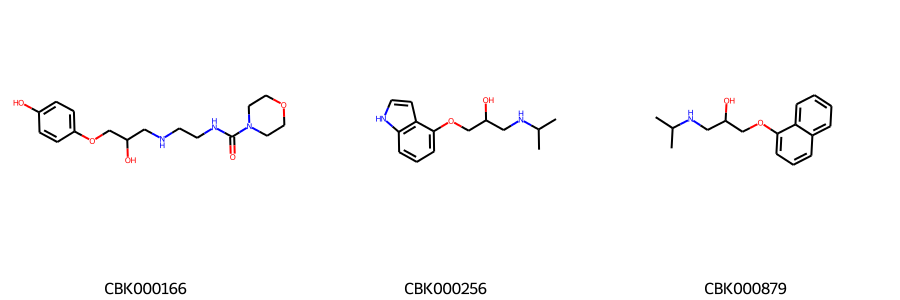

In [9]:
# Compute the descriptors that we're interested in
data['LOGP'] = data['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
data['HAC'] = data['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))

# Plot
#plt.figure(figsize=(8,6))
#data.plot.scatter(x='LOGP', y='HAC')
#plt.show()
PandasTools.FrameToGridImage(data[5:8], column='MOL', legendsCol='ID_library', molsPerRow=3, subImgSize=(300, 300))

In [10]:
data

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL,FRAGS,LOGP,HAC
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,3.05760,25
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,0.98400,20
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,2.04370,21
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,2.60992,20
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,2.36590,23
...,...,...,...,...,...,...,...,...
5167,CBK310019,Cn1c2nc(N3CCNCC3)n(Cc3nnc(o3)-c3ccc(Cl)c(Cl)c3...,0.009855,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,1.24840,33
5168,CBK310020,Brc1cccc2n(C3CCN(CC3)C(=O)Nc3ccc(I)cc3)c(=O)[n...,0.007715,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,4.56570,27
5169,CBK310021,CCOC(=O)c1cnn(c1)-c1cccc2n(C3CCN(CC3)C(=O)Nc3c...,0.010263,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,4.16560,36
5170,CBK310022,COc1ncc(NC(=O)[C@H]2CC[C@H](CC2)n2c3cccc(N(C)C...,0.008265,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,3.47762,31


In [11]:
file_namn = r'/home/jovyan/covid-data/BatchA_for_training.csv'
#data.to_csv(file_namn, sep=',', encoding='utf-8',index=False)

### Training starts!

Parameters and Sets initialization

In [12]:
# Parameters for features
morgan_radius = 2
morgan_n_bits = 1024
fp_n_bits = 2048

# Feature creation
X_morgan, X_rdkit, y = fun.feature_creation(morgan_radius, morgan_n_bits, fp_n_bits, data, labels=True)

In [13]:
X_morgan

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
y

array([0, 0, 0, ..., 0, 0, 0])

## Training without active learning

In [16]:
# Parameters for ML model
train_size = 0.3
test_size = 0.3
n_neighbours = 3

# Models
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
lrg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(max_depth=3, random_state=0)
svmm = svm.SVC(random_state=0)
ada_clf = AdaBoostClassifier(random_state=0) #DecisionTreeClassifier initialized with max_depth=1 and 50 trees

# Data
X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, random_state=6752)

In [26]:
fscores, accs, cf_mat = [], [], []
models = [knn, lrg, rf, svmm, ada_clf]
for model in models:    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc =  accuracy_score(y_test,y_pred)
    f1sc = f1_score(y_test,y_pred)
    fscores.append(f1sc)
    accs.append(acc)
    cf_mat.append(confusion_matrix(y_test, y_pred))
    print(f"The f1-score for model {model} is {f1sc} and the accuracy is {acc}")

The f1-score for model KNeighborsClassifier(n_neighbors=3) is 0.0 and the accuracy is 0.9942028985507246
The f1-score for model LogisticRegression(random_state=0) is 0.25 and the accuracy is 0.9942028985507246
The f1-score for model RandomForestClassifier(max_depth=3, random_state=0) is 0.0 and the accuracy is 0.9942028985507246
The f1-score for model SVC(random_state=0) is 0.0 and the accuracy is 0.9942028985507246
The f1-score for model AdaBoostClassifier(random_state=0) is 0.0 and the accuracy is 0.9893719806763285


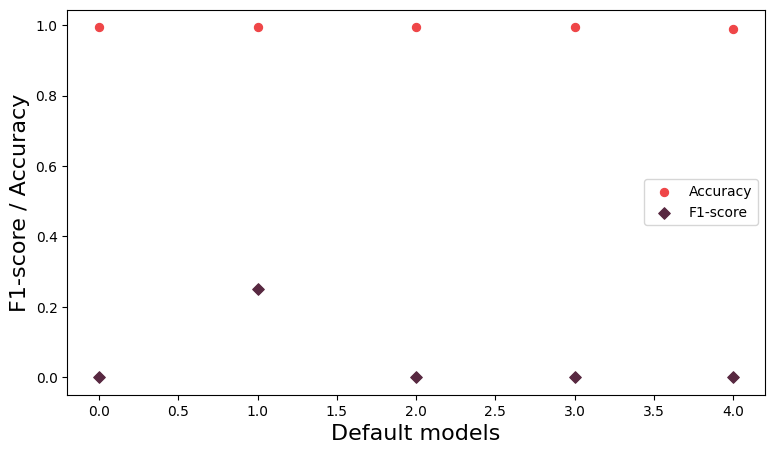

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.scatter(np.arange(len(accs)),accs, marker = 'o', s=35, color=[.937, .275, .282],linewidth=0.8)
ax.scatter(np.arange(len(fscores)),fscores, marker = 'D', s=35, color=[.345, .157, .255],linewidth=0.8)

ax.set_ylabel('F1-score / Accuracy', color="black", fontsize=16)   
ax.set_xlabel('Default models', color="black", fontsize=16)
ax.legend(['Accuracy','F1-score'])

plt.show()